## Predictive Modeling
In this notebook, we explore various models to predict crime type based on various time and location predictors. We initially use holdout cross validation (train/test split) as a fast way to evaluate and compare model performance, but any final models selected can be evaluated on k-fold cross validation to provide more reliable performance measures. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

In [3]:
def multi_performance(y_true, y_pred, classes, y_score=None):
    """
    Returns a dataframe that summarizes performance metrics (accuracy, f1, precision, recall)
    for each class and the overall score (which returns a weighted average of all the scores 
    based on the number of true instances)

    y_true: np.array(n, ); true class labels
    y_pred: np.array(n, ); predicted class labels
    classes: list of class labels (from label_encoder.classes_ for example)
    y_score: currently not used;
    """
    result = np.empty(shape=(3, len(classes)), dtype=np.dtype(object))
    # F1 scores
    result[0] = f1_score(y_true, y_pred, average=None)
    # Precision
    result[1] = precision_score(y_true, y_pred, average=None)
    # Recall
    result[2] = recall_score(y_true, y_pred, average=None)                       
    # Convert result to pandas df
    df = pd.DataFrame(result, columns=classes, index=['f1', 'precision', 'recall'])

    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return df, accuracy

### Process Data
Since the data has many categorical features, we need to encode them in order to use sci-kit learn implementations of the different models. Options that we will explore are:

1. One-hot-encoding. Covert each level of the categorical feature into binary indicator variables. The problem with one-hot-encoding is that it can dramatically increase the dimensionality of the data which will increase the computational cost of training and increases the overfitting risk (increases model variance)

2. Ordinal encoding. Assign each level of the categorical feature an integer. While this does not increase the dimensionality of the data, it can introduce bias since the model can interpret the variables based on its magnitude while in reality the numerical values were arbitrarily assigned. This can be less of an issue with tree-based methods, however.

In [4]:
# Read csv data
df = pd.read_csv('data/clean_data.csv')
# Drop un-needed or already processed columns
df = df.drop(columns=['OBJECTID', 'OCC_HOUR', 'OCC_DATE', 'dayofweek'])

In [5]:
## Get one-hot-encoded data
df1 = pd.get_dummies(df[['NEIGHBOURHOOD_158', 'LOCATION_TYPE']])

# Combine with original data
df_one_hot = pd.concat([df, df1], axis=1)

X_one_hot = df_one_hot.drop(columns=['MCI_CATEGORY', 'NEIGHBOURHOOD_158', 'LOCATION_TYPE'])

In [6]:
X_one_hot

,LONG_WGS84,LAT_WGS84,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,year,month,isholiday,lat_hour_cos,...,LOCATION_TYPE_Religious Facilities,LOCATION_TYPE_Retirement Home,LOCATION_TYPE_Schools During Supervised Activity,LOCATION_TYPE_Schools During Un-Supervised Activity,"LOCATION_TYPE_Single Home, House","LOCATION_TYPE_Streets, Roads, Highways",LOCATION_TYPE_Ttc Admin Or Support Facility,LOCATION_TYPE_Ttc Subway Station,LOCATION_TYPE_Universities / Colleges,LOCATION_TYPE_Unknown
0,-79.350229,43.646293,0.974928,-0.222521,0.707107,0.707107,2014,1,True,30.862590,...,0,0,0,0,0,0,0,0,0,0
1,-79.376497,43.666423,0.974928,-0.222521,0.866025,0.500000,2014,1,True,21.833211,...,0,0,0,0,0,0,0,0,0,0
2,-85.488744,0.000000,0.974928,-0.222521,0.866025,0.500000,2014,1,True,0.000000,...,0,0,0,0,0,1,0,0,0,0
3,-79.344839,43.678946,0.974928,-0.222521,0.866025,0.500000,2014,1,True,21.839473,...,0,0,0,0,0,1,0,0,0,0
4,-79.391841,43.646639,0.974928,-0.222521,0.500000,0.866025,2014,1,True,37.799098,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321838,-79.301740,43.736102,0.433884,-0.900969,0.866025,-0.500000,2022,12,False,-21.868051,...,0,0,0,0,1,0,0,0,0,0
321839,-79.258639,43.828794,-0.974928,-0.222521,0.707107,0.707107,2022,12,False,30.991637,...,0,0,0,0,0,0,0,0,0,0
321840,-79.425645,43.701404,0.433884,-0.900969,-0.866025,-0.500000,2022,12,False,-21.850702,...,0,0,0,0,0,0,0,0,0,0
321841,-79.385170,43.672134,-0.974928,-0.222521,0.866025,0.500000,2022,12,False,21.836067,...,0,0,0,0,0,0,0,0,0,0


In [7]:
## Get ordinal encoded data
ordinal_encoder = OrdinalEncoder()
df_ordinal = df.copy() # write on top of a copy of df
df_ordinal.loc[:, ['NEIGHBOURHOOD_158', 'LOCATION_TYPE']] = ordinal_encoder.fit_transform(df[['NEIGHBOURHOOD_158', 'LOCATION_TYPE']]) # create labels

X_ordinal = df_ordinal.drop(columns=['MCI_CATEGORY'])

In [8]:
## Process y with label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['MCI_CATEGORY'])

# Encoded classes
classes = label_encoder.classes_
classes

array(['Assault', 'Auto Theft', 'Break and Enter', 'Robbery',
       'Theft Over'], dtype=object)

### Multi-class Logistic Regression
We begin using multi-class logistic regression (multi-nomial loss) which can be fit more quickly than other methods. Multiclass logistic regression assumes a linear relationship between the log-ratio of probabilities between classes and the predictor variables, which is not likely too be true for our dataset. For example, the relationship is likely to be nonlinear with GPS coordinates. However, because logistic regression can be fit easily, it can provide a good baseline before conducting more complex analysis.

Note that we have to use dummy encoding instead of one-hot-encoding or else the linear solution will not be well defined (that is, k-1 indicators instead of k for a variable with k categories). Additionally, we standardize the numerical data to help the optimizer converge.

In [39]:
# Select numerical features and standardize them
numerical_df = df.select_dtypes(include=np.number)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

In [40]:
# Get dummy variables
dummy_vars = pd.get_dummies(df[['NEIGHBOURHOOD_158', 'LOCATION_TYPE']], drop_first=True)
# Combine with original data
df_dummies = pd.concat([df, dummy_vars], axis=1)

In [41]:
# Add standardized numerical features
df_dummies[numerical_df.columns] = scaled_data

In [44]:
# Drop unneeded columns
X_dummies = df_dummies.drop(columns=['MCI_CATEGORY', 'NEIGHBOURHOOD_158', 'LOCATION_TYPE'])

In [46]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=0)

In [52]:
# Fit multiclass logistic regression
logistic_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)
logistic_reg.fit(X_train, y_train)

# Get predicted values
y_pred = logistic_reg.predict(X_test)

In [55]:
# Evaluate performance
multi_performance(y_true=y_test, y_pred=y_pred, classes=classes)[0]

In [54]:
# Overall accuracy
multi_performance(y_true=y_test, y_pred=y_pred, classes=classes)[1]

0.614129027580707

### Random Forest
Random Forest is capable of handling mixed data types, performs automatic feature selection, is robust to outliers, and discovers non-linear relationships. Additionally, random forest is not prone to overfitting and does not require much hyper-parameter tuning, if at all. Since Random Forest averages many different decision trees, it is also not prone to overfitting and has low variance in the bias-variance tradeoff. RF is also useful because it discovers feature importance scores, although this needs to be carefully interpreted if there are colinear variables or if variables are of high cardinality.

In [16]:
# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_one_hot, y, test_size=0.3, random_state=0)

In [56]:
# Fit model
rf = RandomForestClassifier()
rf.fit(X_train1, y_train1)

# Get predictions
y_pred1 = rf.predict(X_test1)

In [57]:
# Evaluate performance 
multi_performance(y_true=y_test1, y_pred=y_pred1, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.773323,0.62177,0.566042,0.495736,0.055842
precision,0.705969,0.644005,0.633427,0.653506,0.20078
recall,0.854885,0.601019,0.511616,0.399329,0.032431


In [58]:
# Overall accuracy
multi_performance(y_true=y_test1, y_pred=y_pred1, classes=classes)[1]

0.6804035089536317

We can also try fitting a random forest using the ordinal encoded data.

In [59]:
# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_ordinal, y, test_size=0.3, random_state=1)

# Fit model
rf2 = RandomForestClassifier()
rf2.fit(X_train2, y_train2)

# Get predictions
y_pred2 = rf2.predict(X_test2)

In [60]:
# Evaluate performance
multi_performance(y_true=y_test2, y_pred=y_pred2, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.765704,0.60207,0.537755,0.456294,0.056128
precision,0.685937,0.642502,0.629045,0.675234,0.244389
recall,0.866464,0.566426,0.469604,0.34457,0.031705


In [61]:
# Overall accuracy
multi_performance(y_true=y_test2, y_pred=y_pred2, classes=classes)[1]

0.6698600768489845

The performance dropped very slightly compared to the one-hot-encoded data. We also can get insight from the feature importance plot (which would be harder to interpret for the one-hot-encoded data). This suggests that the location type, the GPS coordinates, and the interaction between time of day and location are important variables.

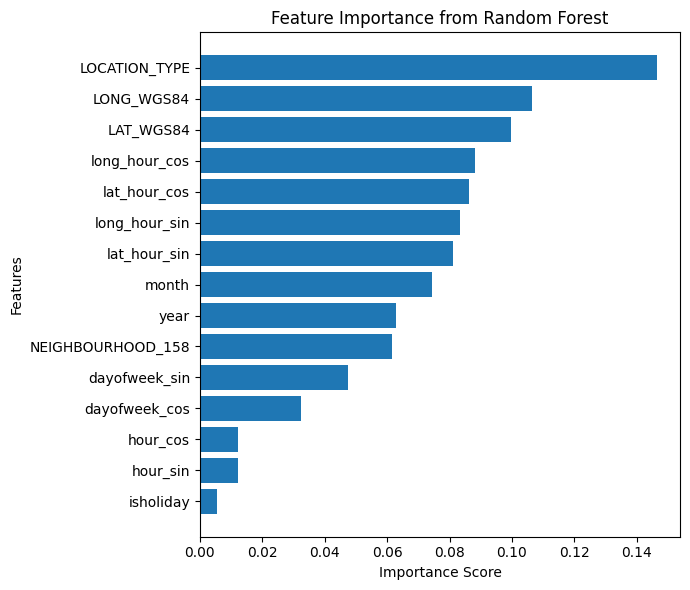

In [62]:
# Get importance scores from the RF model and sort them
importances = rf2.feature_importances_
feature_names = X_train2.columns
indices = np.argsort(importances)
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot results
plt.figure(figsize=(7, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

### Random Forest - Weighted Random Forest
Note that performance is poor for most crime types, except for assault and auto-theft. At the same time, the dataset is unbalanced towards assaults, although not severely. Thus, we can try running a Weighted Random Forest (by weighting the impurity calculations for the constituent decision trees toward the minority classes, we can penalize missclassifications on the minority classes more).

In [63]:
# Review class frequencies in the data
df.MCI_CATEGORY.value_counts() / df.MCI_CATEGORY.value_counts().sum()

Assault            0.534758
Break and Enter    0.193989
Auto Theft         0.142905
Robbery            0.095363
Theft Over         0.032985
Name: MCI_CATEGORY, dtype: float64

In [64]:
# Fit model (weighted based on dataset frequency)
rf_weighted = RandomForestClassifier(class_weight='balanced')
rf_weighted.fit(X_train1, y_train1)

# Get predictions
y_pred1_weighted = rf_weighted.predict(X_test1)

In [65]:
# Evaluate performance
multi_performance(y_true=y_test1, y_pred=y_pred1_weighted, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.771617,0.618728,0.561035,0.499933,0.056506
precision,0.701374,0.647326,0.636596,0.656519,0.205941
recall,0.857496,0.59255,0.501508,0.403657,0.032746


In [66]:
multi_performance(y_true=y_test1, y_pred=y_pred1_weighted, classes=classes)[1]

0.679015670150073

In [67]:
# Fit model (weighted based on bootstrap frequency)
rf_weighted2 = RandomForestClassifier(class_weight='balanced_subsample')
rf_weighted2.fit(X_train1, y_train1)

# Get predictions
y_pred1_weighted2 = rf_weighted2.predict(X_test1)

In [68]:
# Evaluate performance
multi_performance(y_true=y_test1, y_pred=y_pred1_weighted2, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.771265,0.619522,0.562061,0.502575,0.054743
precision,0.702205,0.644898,0.63609,0.658199,0.196498
recall,0.855391,0.596067,0.503466,0.40647,0.031801


In [69]:
multi_performance(y_true=y_test1, y_pred=y_pred1_weighted2, classes=classes)[1]

0.6790260271560697

Unfortunately, the Weighted Random Forest did not improve the situation much.

### Random Forest - Minority Class Oversampling
Another way that we can deal with class imbalance is oversampling the minority class. To do so we need to make the assumptions:

1. The oversampling minority classes are exchangeable with the existing observations. In other words, the synthetic minority cases should come from the same underlying distribution as the existing minority class observations.

2. The synthetic minority cases should be independent of each other so that we do not learn spurious correlations between them.

Additionally, note that by oversampling the existing minority cases, we also give more weight to the noise inherent in the existing cases. This may lead to the risk of overfitting, and reduce the generalization ability of the model.

In [50]:
# Instance of random oversampler
oversampler = RandomOverSampler(random_state=0)

# Resample data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train1, y_train1)


In [70]:
# Review class frequencies in the resampled data
np.unique(y_train_resampled, return_counts=True)[1]

array([120804, 120804, 120804, 120804, 120804])

In [71]:
# Fit model
rf_rs = RandomForestClassifier()
rf_rs.fit(X_train_resampled, y_train_resampled)

# Get predictions
y_pred1_rs = rf_rs.predict(X_test1)

In [72]:
# Evaluate performance
multi_performance(y_true=y_test1, y_pred=y_pred1_rs, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.757699,0.626837,0.584578,0.502014,0.09611
precision,0.739178,0.606044,0.589133,0.545132,0.175879
recall,0.777171,0.649106,0.580092,0.465217,0.066121


In [78]:
# Overall accuracy
multi_performance(y_true=y_test1, y_pred=y_pred1_rs, classes=classes)[1]

0.6668669021159364

The out of sample performance for Theft Over $5000 improved significantly, but not to acceptable levels.

### Gradient Boosted Trees (xgboost)
We try a different algorithm to deal with the low performance on the minority classes. Gradient boosting may be a good algorithm to consider because of its sequential nature, where each subsequent model focuses more on the previous model's missclassifications. This is usually a good way to reduce bias, and in our case, it may help with the low performance on the minority classes. Here, I implement gradient boosted trees using the xgboost package.

### GBT - Hyperparameter Tuning
We conduct hyperparameter tuning using Randomized Search over the given hyper-parameter space. This is much more efficient than an exhuastive search but may not find the global best parameters. Here, we evaluate the performance using k-fold cross validation on the training data using the weighted f1 score.

In [37]:
# Hyperparameter search space
param_space = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'n_estimators': [100, 200, 300, 400, 500]
}

In [38]:
# Initialize XGBoost classifier (gpu_hist enables training on gpu)
xgb_classifier = xgb.XGBClassifier(objective = 'multi:softmax',
                                   num_class = 5, tree_method='gpu_hist', 
                                   gpu_id=0)

In [40]:
# Initialize random search (-1 jobs uses all avail processors)
random_search = RandomizedSearchCV(
    xgb_classifier, param_distributions=param_space,
    n_iter=10, scoring='f1_weighted', n_jobs=-1, cv=5, verbose=1
)

In [41]:
# Conduct random search
random_search.fit(X_train1, y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=0,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=No...
                                           num_class=5, num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1]},
                   scoring='f1_weighted', verbose=1)

In [42]:
# Get the best parameters and best score
best_params = random_search.best_params_
best_params

{'subsample': 0.8,
 'n_estimators': 400,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 0.8}

In [43]:
best_score = random_search.best_score_
best_score

0.6448528580043158

### GBT - fit using resulting hyperparameters

In [44]:
# Fit the model
xgb_classifier = xgb.XGBClassifier(**best_params, objective = 'multi:softmax',
                                   num_class = 5, tree_method='gpu_hist', 
                                   gpu_id=0)

xgb_classifier.fit(X_train1, y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_class=5,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [45]:
# Get predicted values
y_pred1_xgb = xgb_classifier.predict(X_test1)

In [47]:
# Evaluate performance
multi_performance(y_true=y_test1, y_pred=y_pred1_xgb, classes=classes)[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.771462,0.616528,0.586584,0.371866,0.069063
precision,0.695713,0.639519,0.650654,0.628866,0.341737
recall,0.865722,0.595134,0.534,0.263984,0.038413


In [48]:
# Overall accuracy
multi_performance(y_true=y_test1, y_pred=y_pred1_xgb, classes=classes)[1]

0.6769339119447351

Unfortunately, performance did not noticeably improve compared to the random forest. 

### Review Model Performance

In [76]:
# ## Save performance results

# # List of different predicted values
# y_pred_ls = [y_pred1,
#              y_pred2,
#              y_pred1_weighted,
#              y_pred1_weighted2,
#              y_pred1_rs,
#              y_pred1_xgb]

# # Corresponding model names
# model_names =['RF: one-hot',
#               'RF: ordinal',
#               'RF: weighted',
#               'RF: bootstrap weighted',
#               'RF: oversampling',
#               'xgboost']

# # Initialize list to store accuracies
# accuracy_ls = []

# for i, y_hat in enumerate(y_pred_ls):
#   if model_names[i] != 'RF: ordinal': 
#     # Save accuracy
#     accuracy_ls.append(multi_performance(y_true=y_test1, 
#                                          y_pred=y_hat, classes=classes)[1])
#     # Save other metrics as csv
#     multi_performance(y_true=y_test1, 
#                       y_pred=y_hat, 
#                       classes=classes)[0].to_csv(f'data/model_performance/{model_names[i]}.csv')
    
#   else:
#     # Save accuracy
#     accuracy_ls.append(multi_performance(y_true=y_test2, 
#                                          y_pred=y_hat, classes=classes)[1])
#     # Save other metrics as csv
#     multi_performance(y_true=y_test2, 
#                       y_pred=y_hat, 
#                       classes=classes)[0].to_csv(f'data/model_performance/{model_names[i]}.csv')


In [79]:
# pd.DataFrame({'accuracy': accuracy_ls},
#              index=model_names).to_csv('data/model_performance/accuracies.csv')

Below we plot the performance of the different models.

In [34]:
# Load in model accuracies
accuracies = pd.read_csv('data/model_performance/accuracies.csv', index_col=0)

# Load in other metrics
model_filename = ['RF_one-hot',
              'RF_ordinal',
              'RF_weighted',
              'RF_bootstrap weighted',
              'RF_oversampling',
              'xgboost',
              'multi_logistic']
model_perf = []
for model in model_filename:
    model_perf.append(pd.read_csv(f'data/model_performance/{model}.csv', index_col=0))


In [32]:
model_perf[0]

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
f1,0.773323,0.621770,0.566042,0.495736,0.055842
precision,0.705969,0.644005,0.633427,0.653506,0.200780
recall,0.854885,0.601019,0.511616,0.399329,0.032431


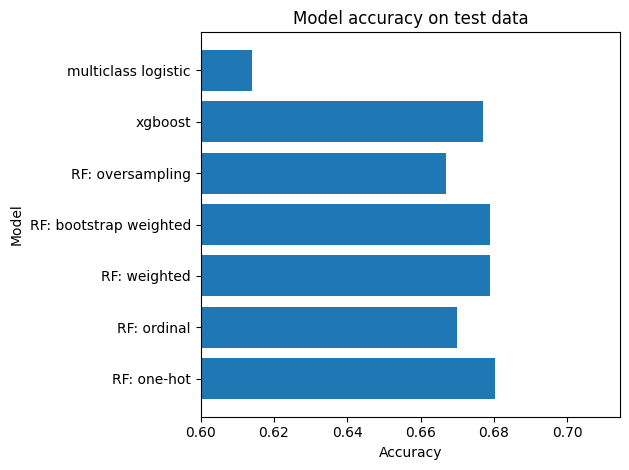

In [31]:
# Plot model accuracies
fig, ax = plt.subplots()
ax.barh(y=accuracies.index, width=accuracies['accuracy'])
ax.set_xlim(left=0.6)
ax.set_title('Model accuracy on test data')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Model')
plt.tight_layout()
plt.show()

In [42]:
## Collect performance metrics for each model
model_names =['RF: one-hot',
              'RF: ordinal',
              'RF: weighted',
              'RF: bootstrap weighted',
              'RF: oversampling',
              'xgboost',
              'multiclass logistic']
# Collect f1 scores and convert to df
f1_scores = [(lambda x: x.loc['f1', :])(model) for model in model_perf]
f1_scores = pd.DataFrame(f1_scores, index=model_names)

# Collect precision
precision_scores = [(lambda x: x.loc['precision', :])(model) for model in model_perf]
precision_scores = pd.DataFrame(precision_scores, index=model_names)

# Collect precision
recall_scores = [(lambda x: x.loc['recall', :])(model) for model in model_perf]
recall_scores = pd.DataFrame(recall_scores, index=model_names)

In [44]:
precision_scores

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
RF: one-hot,0.705969,0.644005,0.633427,0.653506,0.200780
RF: ordinal,0.685937,0.642502,0.629045,0.675234,0.244389
RF: weighted,0.701374,0.647326,0.636596,0.656519,0.205941
RF: bootstrap weighted,0.702205,0.644898,0.636090,0.658199,0.196498
RF: oversampling,0.739178,0.606044,0.589133,0.545132,0.175879
xgboost,0.695713,0.639519,0.650654,0.628866,0.341737
multiclass logistic,0.636996,0.575803,0.534674,0.575085,0.500000


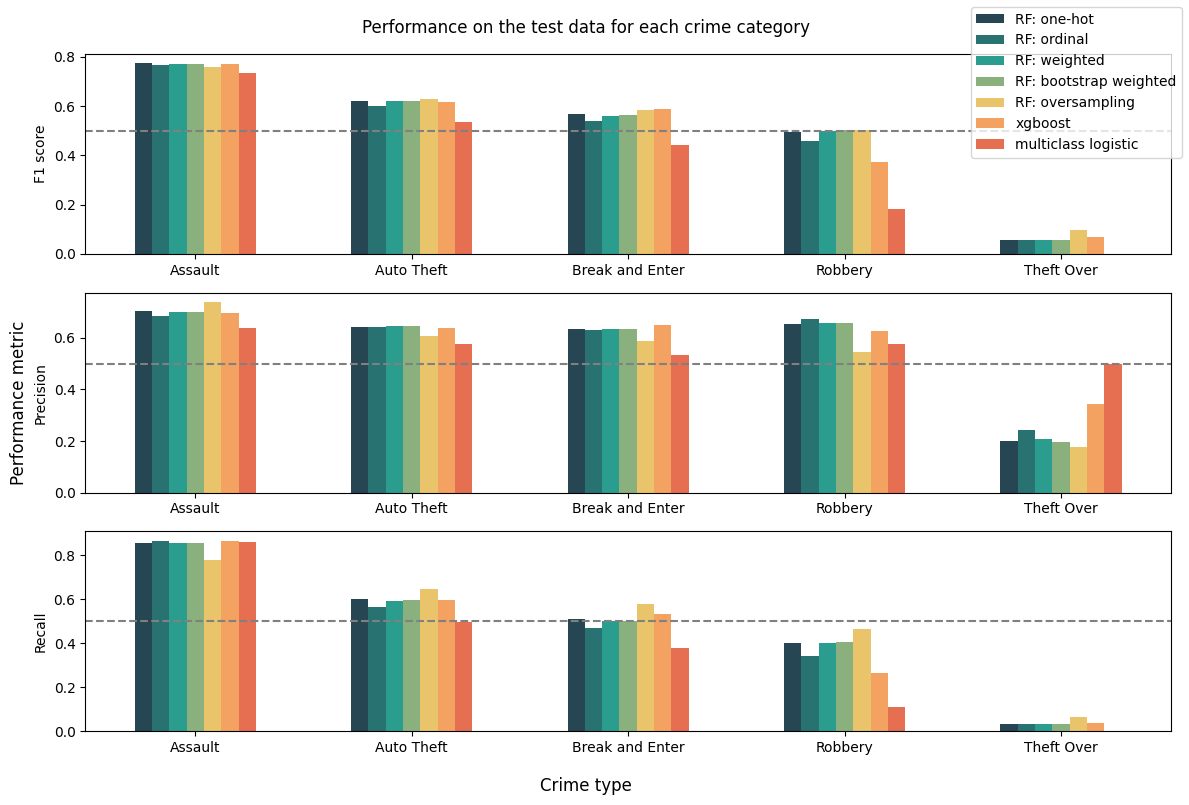

In [83]:
# Create plot
fig, axes = plt.subplots(nrows=3, figsize=(12, 8))
barwidth = 0.08

# Define colors
colors = ['#264653', '#287271', '#2A9D8F', '#8AB17D', '#E9C46A', '#F4A261', '#E76F51']

# Set position of bar on x axis
br1 = np.arange(5)
br2 = [x + barwidth for x in br1]
br3 = [x + barwidth for x in br2]
br4 = [x + barwidth for x in br3]
br5 = [x + barwidth for x in br4]
br6 = [x + barwidth for x in br5]
br7 = [x + barwidth for x in br6]

# Plot scores
scores_ls = [f1_scores, precision_scores, recall_scores]
score_names = ['F1 score', 'Precision', 'Recall']

for i in range(3):
    axes[i].bar(br1, scores_ls[i].loc['RF: one-hot', :], color =colors[0], width = barwidth, label ='RF: one-hot')
    axes[i].bar(br2, scores_ls[i].loc['RF: ordinal', :], color =colors[1], width = barwidth, label = 'RF: ordinal')
    axes[i].bar(br3, scores_ls[i].loc['RF: weighted', :], color =colors[2], width = barwidth, label = 'RF: weighted')
    axes[i].bar(br4, scores_ls[i].loc['RF: bootstrap weighted', :], color =colors[3], width = barwidth, label = 'RF: bootstrap weighted')
    axes[i].bar(br5, scores_ls[i].loc['RF: oversampling', :], color =colors[4], width = barwidth, label = 'RF: oversampling')
    axes[i].bar(br6, scores_ls[i].loc['xgboost', :], color =colors[5], width = barwidth, label = 'xgboost')
    axes[i].bar(br7, scores_ls[i].loc['multiclass logistic', :], color =colors[6], width = barwidth, label = 'multiclass logistic')
    axes[i].axhline(y=0.5, color='grey', ls='--')
    axes[i].set_xticks([r + 3*barwidth for r in range(5)], f1_scores.columns)
    axes[i].set_ylabel(score_names[i])

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1)
fig.suptitle('Performance on the test data for each crime category')
fig.supxlabel('Crime type')
fig.supylabel('Performance metric')
plt.tight_layout()
plt.show()